# Titanic: Machine Learning from Disaster

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns 
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
train_data = pd.read_csv('data/train.csv', index_col='PassengerId')
test_data = pd.read_csv('data/test.csv', index_col='PassengerId')

In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Ticket      891 non-null object
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [4]:
train_data.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
train_data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
corr_matrix = train_data.corr()

corr_matrix['Survived']

Survived    1.000000
Pclass     -0.338481
Age        -0.077221
SibSp      -0.035322
Parch       0.081629
Fare        0.257307
Name: Survived, dtype: float64

## Distribution of the data

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4c5efb5b90>,
      dtype=object)

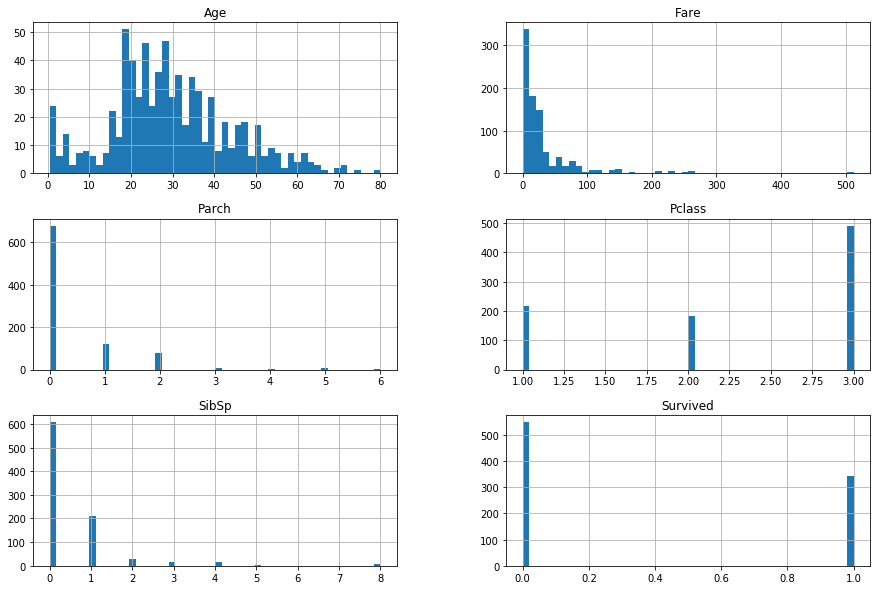

In [7]:
train_data.hist(bins=50, figsize=(15,10))

## Evaluating the Null values

In [8]:
train_data.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

## Time to take decisions

### Facts

- In total we have 891 samples

- We see there are some Features with null values like:

    - Age        ->  177
    - Cabin      ->  687
    - Embarked   ->  2

### Decisions

- Drop Cabin feature (Too many null values)

- Drop Ticket feature (It does not provide too much information)

- Replace Embarked null values with most frequent strategy 

- Given that we have the title of Passengers in Name feature, we'll use it to get an approximated age, and impute that value to the ones who age is unknown (Age is considered to be important)

- Sum Parch and SibSp features into one single feature which will represent the total members of family of a passenger inside Titanic

In [9]:
train_data['FamilyMembers'] = train_data['SibSp'] + train_data['Parch']
test_data['FamilyMembers'] = test_data['SibSp'] + test_data['Parch']

train_data.drop(['Cabin', 'Ticket', 'SibSp', 'Parch'], axis=1, inplace=True)
test_data.drop(['Cabin', 'Ticket', 'SibSp', 'Parch'], axis=1, inplace=True)

In [10]:
from sklearn.base import BaseEstimator, TransformerMixin

class MeanAgeImputer(BaseEstimator, TransformerMixin):

    def __init__(self, delete_title=True, delete_name=True): 
        self.delete_title = delete_title
        self.delete_name = delete_name

    def get_title(self, name):
        return name.split(', ')[1].split('.')[0]

    def get_title_series(self, names, index):
        return pd.Series(map(self.get_title, names), index=index)
        
    def fit(self, X, y=None):

        # Dealing with Honorifics

        X_copy = X.copy()
        
        title_series = self.get_title_series(X_copy.Name[:], X_copy.index)

        X_copy['Title'] = title_series

        # Dealing with the mean

        only_title_age = X_copy[['Title', 'Age']]
        
        mean_age_per_title = only_title_age.groupby(['Title']).mean().round(1)

        self.mean_age_per_title = mean_age_per_title

        return self 

    def transform(self, X, y=None):

        # Dealing with Honorifics

        title_series = self.get_title_series(X.Name[:], X.index)

        X['Title'] = title_series

        # Dealing with the mean

        age_is_nan = X['Age'].isna()

        for title in list(self.mean_age_per_title.index):
            X.loc[((X['Title'] == title) & (age_is_nan)), 'Age'] = np.float64(self.mean_age_per_title.loc[title])
        
        if (self.delete_title):
            X.drop(['Title'], axis=1, inplace=True)

        if (self.delete_name):        
            X.drop(['Name'], axis=1, inplace=True)

        return X

In [11]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 8 columns):
Survived         891 non-null int64
Pclass           891 non-null int64
Name             891 non-null object
Sex              891 non-null object
Age              714 non-null float64
Fare             891 non-null float64
Embarked         889 non-null object
FamilyMembers    891 non-null int64
dtypes: float64(2), int64(3), object(3)
memory usage: 62.6+ KB


## Preprocessing the data

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

age_pipeline = Pipeline([
    ('mean_age', MeanAgeImputer()),
    ('std_scaler', StandardScaler())
])

num_pipeline = Pipeline([
    ('mean_fare', SimpleImputer(strategy='mean')),
    ('min_max_scaler', MinMaxScaler())
])

cat_pipeline = Pipeline([
    ('frequent_imputer', SimpleImputer(strategy='most_frequent')),
    ('OH_encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

full_pipeline = ColumnTransformer([
    ('age_pipeline_imputer', age_pipeline, ['Age', 'Name']),
    ('fare_pipeline', num_pipeline, ['Fare', 'FamilyMembers']),
    ('cat', cat_pipeline, ['Sex', 'Embarked', 'Pclass'])
])


In [13]:
# Training Set

y_train = train_data[['Survived']]

X_train = train_data.drop(['Survived'], axis=1)

In [14]:
X_train = full_pipeline.fit_transform(X_train)

X_test = full_pipeline.transform(test_data)

## Testing some models

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error

loogistic_classifier = LogisticRegression()

loogistic_classifier.fit(X_train, y_train)

logistic_predictions = loogistic_classifier.predict(X_train)

logistic_rmse = np.sqrt(mean_squared_error(y_train, logistic_predictions))

print(f"Logistic RMSE: {logistic_rmse}")

Logistic RMSE: 0.4457052822810143


In [16]:
from sklearn.svm import SVC

SVC_classifier = SVC(kernel='rbf')

SVC_classifier.fit(X_train, y_train)

SVC_predictions = SVC_classifier.predict(X_train)

SVC_rmse = np.sqrt(mean_squared_error(y_train, SVC_predictions))

print(f"SVC RMSE: {SVC_rmse}")

SVC RMSE: 0.4250833416666831


In [17]:
from xgboost import XGBClassifier

XGB_classifier = XGBClassifier()

XGB_classifier.fit(X_train, y_train)

XGB_predictions = XGB_classifier.predict(X_train)

XGB_rmse = np.sqrt(mean_squared_error(y_train, XGB_predictions))

print(f"XGB RMSE: {XGB_rmse}")

XGB RMSE: 0.1865271243698928


### Got better performance with XGB Classifier

## Trying to tune the model

In [18]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [100, 150, 200], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [100, 150, 200], 'max_features': [2, 3, 4]},
]

XGB_classifier_with_cv = XGBClassifier()

XGB_classifier_with_cv = GridSearchCV(XGB_classifier_with_cv, param_grid, cv=5,
                            scoring='neg_mean_squared_error',
                            return_train_score=True)

XGB_classifier_with_cv.fit(X_train, y_train)

predictions = XGB_classifier_with_cv.predict(X_train)

XGB_with_cv_rmse = np.sqrt(mean_squared_error(y_train, predictions))

print(f"XGB with CV RMSE: {XGB_with_cv_rmse}")

XGB with CV RMSE: 0.1865271243698928


### Got same RMSE, decided to continue with default parameters

## Making the final predictions, for submission

In [19]:
y_pred = XGB_classifier.predict(X_test)

In [20]:
y_pred_df = pd.DataFrame(data=y_pred,    
                        index=range(892, 1310),    
                        columns=['Survived'])

y_pred_df.index.names = ['PassengerId']

In [21]:
from os.path import join

filename = 'submission.csv'
path = join('data', filename)

y_pred_df.to_csv(path)